In [1]:
import gdown, IPython 
gdown.download('https://drive.google.com/file/d/197jrNs8NP5I33qAIAaGwuSWQVmyE9Ee4/view?usp=sharing', 'decorated_header.html', quiet=True, fuzzy=True)
IPython.display.HTML(filename="decorated_header.html") # the author of the style: https://codepen.io/juanbrujo/pen/DBKxxM

### **Dane**
> Eurostat (average full time adjusted salary 2021):
> https://ec.europa.eu/eurostat/databrowser/view/NAMA_10_FTE__custom_4232263/bookmark/table?lang=en&bookmarkId=fafb4e3b-f3aa-4907-9102-16be8df6f775

### **Przygotowanie danych**

In [2]:
data_url = 'https://drive.google.com/file/d/1eNEmSm92NxSQIvKKPqieCloNP1INpAga/view?usp=sharing'
data_file = 'average_adjusted_salary_2021.csv'
gdown.download(data_url, data_file, quiet=True, fuzzy=True)

'average_adjusted_salary_2021.csv'

In [3]:
# Odczyt danych z pliku
import csv
salary_dictionary = {}

with open(data_file, 'r') as data_csv_file:
    reader = csv.DictReader(data_csv_file, ["country", "value"], delimiter=';')
    for row in reader:
      salary_dictionary[row['country']] = row['value'].replace(' ', '');

# Sortowanie słownika
salary_dictionary = sorted(salary_dictionary.items(), key=lambda x:x[1])

# Sprawdzenie poprawności
print(salary_dictionary)

[('Bulgaria', '10345'), ('Hungary', '12618'), ('Romania', '13000'), ('Poland', '14431'), ('Greece', '15879'), ('Slovakia', '16162'), ('Croatia', '16169'), ('Czechia', '18189'), ('Latvia', '18707'), ('Portugal', '19301'), ('Estonia', '21481'), ('Lithuania', '21741'), ('Cyprus', '22734'), ('Malta', '27334'), ('Spain', '28184'), ('Slovenia', '28765'), ('Italy', '29951'), ('France', '40135'), ('Finland', '43193'), ('Germany', '44404'), ('Sweden', '46934'), ('Austria', '48317'), ('Belgium', '48722'), ('Ireland', '50347'), ('Denmark', '63261'), ('Luxembourg', '72247')]


### **Generowanie dokumentów PostScript**

In [4]:
# Tworzenie katalogu do przechowywania wyników
!rm -r --force results
!mkdir results
!mkdir results/ps

In [5]:
# Funkcja generująca plik PostScript
def draw(country, value, max_value, color_scheme, index):
  
  offset =-40
  if len(country) > 7:
    offset = -60

  script = """
/drawEllipse {{
  0.9 rotate
  2 1 scale
  0 0 100 0 360 arc stroke
  1 2 div 1 scale
}} def

297.5 421 translate

/red 1 def
/green 1 def
/blue 0 def

{numberOfEllipses} {{
  red green blue setrgbcolor
  drawEllipse
  /red red 1 add {color_1} mod def
  /green green 1 add {color_2} mod def
  /blue blue 1 add {color_3} mod def
}} repeat

/Courier-Bold findfont 20 scalefont setfont
0 0 0 setrgbcolor
-0.9 {numberOfEllipses} mul rotate
{textOffset} 0 moveto
({title}) show

/Times-Italis-ISOLatin1 findfont 10 scalefont setfont
-35 -30 moveto
({value} EUR/year) show

showpage
""".format(numberOfEllipses = round(int(value) / int(max_value) * 200), title = country, 
           color_1 = color_scheme[0], color_2 = color_scheme[1], color_3 = color_scheme[2],
           textOffset = offset, value = round(float(value)))
  output = 'results/ps/{}_{}.ps'.format(index, country.replace(' ', '_'))

  with open(output, 'w') as f:
    f.write(script)

In [6]:
# Generowanie plików PostScript
for i in range(len(salary_dictionary)):
  draw(salary_dictionary[i][0], salary_dictionary[i][1], salary_dictionary[-1][1], [3, 2, 1], i + 1)

# Tworzenie wykresu dla średniej
values = []
for i in range(len(salary_dictionary)):
  values.append(int(salary_dictionary[i][1]))
average = sum(values) / len(values)  
draw('EU average', average, salary_dictionary[-1][1], [1, 2, 3], len(values) + 1)

# Tworzenie wykresu dla studenta UJ otrzymającego stypendium Rektora (1 EUR ~ 4.47 PLn)
draw('UJ student', 9000 / 4.47, salary_dictionary[-1][1], [3, 2, 1], 0)

# Przygotowanie dokumentacji
readme = """>>> Każda elipsa to {0} EUR (precyzja: max = 200 elips). 
>>> Cały wykres to średnie roczne wynagrodzenie mieszkańca danego kraju.

Najwięcej się zarabiało w {1}: {2} EUR/year.
Najmniej w {3}: {4} EUR/year.
Średnia na całą UE: {5} EUR/year.""".format(
    round(int(salary_dictionary[-1][1]) / 200),
    salary_dictionary[-1][0], salary_dictionary[-1][1],
    salary_dictionary[0][0], salary_dictionary[0][1],
    round(average))

with open('results/README.txt', 'w') as f:
  f.write(readme)

print(readme)

>>> Każda elipsa to 361 EUR (precyzja: max = 200 elips). 
>>> Cały wykres to średnie roczne wynagrodzenie mieszkańca danego kraju.

Najwięcej się zarabiało w Luxembourg: 72247 EUR/year.
Najmniej w Bulgaria: 10345 EUR/year.
Średnia na całą UE: 30483 EUR/year.


In [ ]:
# Instalacja pakietu potrzebnego do konwersji plików PostScript do PDF
!sudo apt-get install ghostscript

In [8]:
# Zapis plików PDF
!cp -R results/ps results/temp
!for FILE in results/temp/*; do mv -- "$FILE" "${FILE%.ps}"; done
!for FILE in results/temp/*; do ps2pdf $FILE; done
!mkdir results/pdf
!for FILE in *.pdf; do mv -- "$FILE" results/pdf/$FILE; done
!rm -r --force results/temp

In [ ]:
# Instalacja pakietu potrzebnego do konwersji plików PDF do PNG
!sudo apt install poppler-utils

In [ ]:
# Zapis plików PNG
!for FILE in results/pdf/*.pdf; do pdftoppm "$FILE" "${FILE%.pdf}" -png; done
!mkdir results/png
!mv -v results/pdf/*.png results/png
!for FILE in results/png/*; do mv "${FILE}" "${FILE/-1/}"; done

In [11]:
# Pobranie wygenerowanych obrazków
!zip -r -q results.zip results

from google.colab import files
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Podgląd wyników**

---


#### **Wizualizacja oparta o liczność, kąt i pole**.

---



In [ ]:
!mkdir samples
gdown.download("https://drive.google.com/file/d/10OKbMxchbGnWl_5DWv5LCShZ1PMuL9VQ/view?usp=sharing", "samples/1.png", quiet=True, fuzzy=True)
gdown.download("https://drive.google.com/file/d/10HQ9KQtMmKxaczTx7tAs00NI9WWTba91/view?usp=sharing", "samples/2.png", quiet=True, fuzzy=True)
gdown.download("https://drive.google.com/file/d/10Cfcl6Rt_FAhsFv7Ldwe4E096629lVlB/view?usp=sharing", "samples/3.png", quiet=True, fuzzy=True)

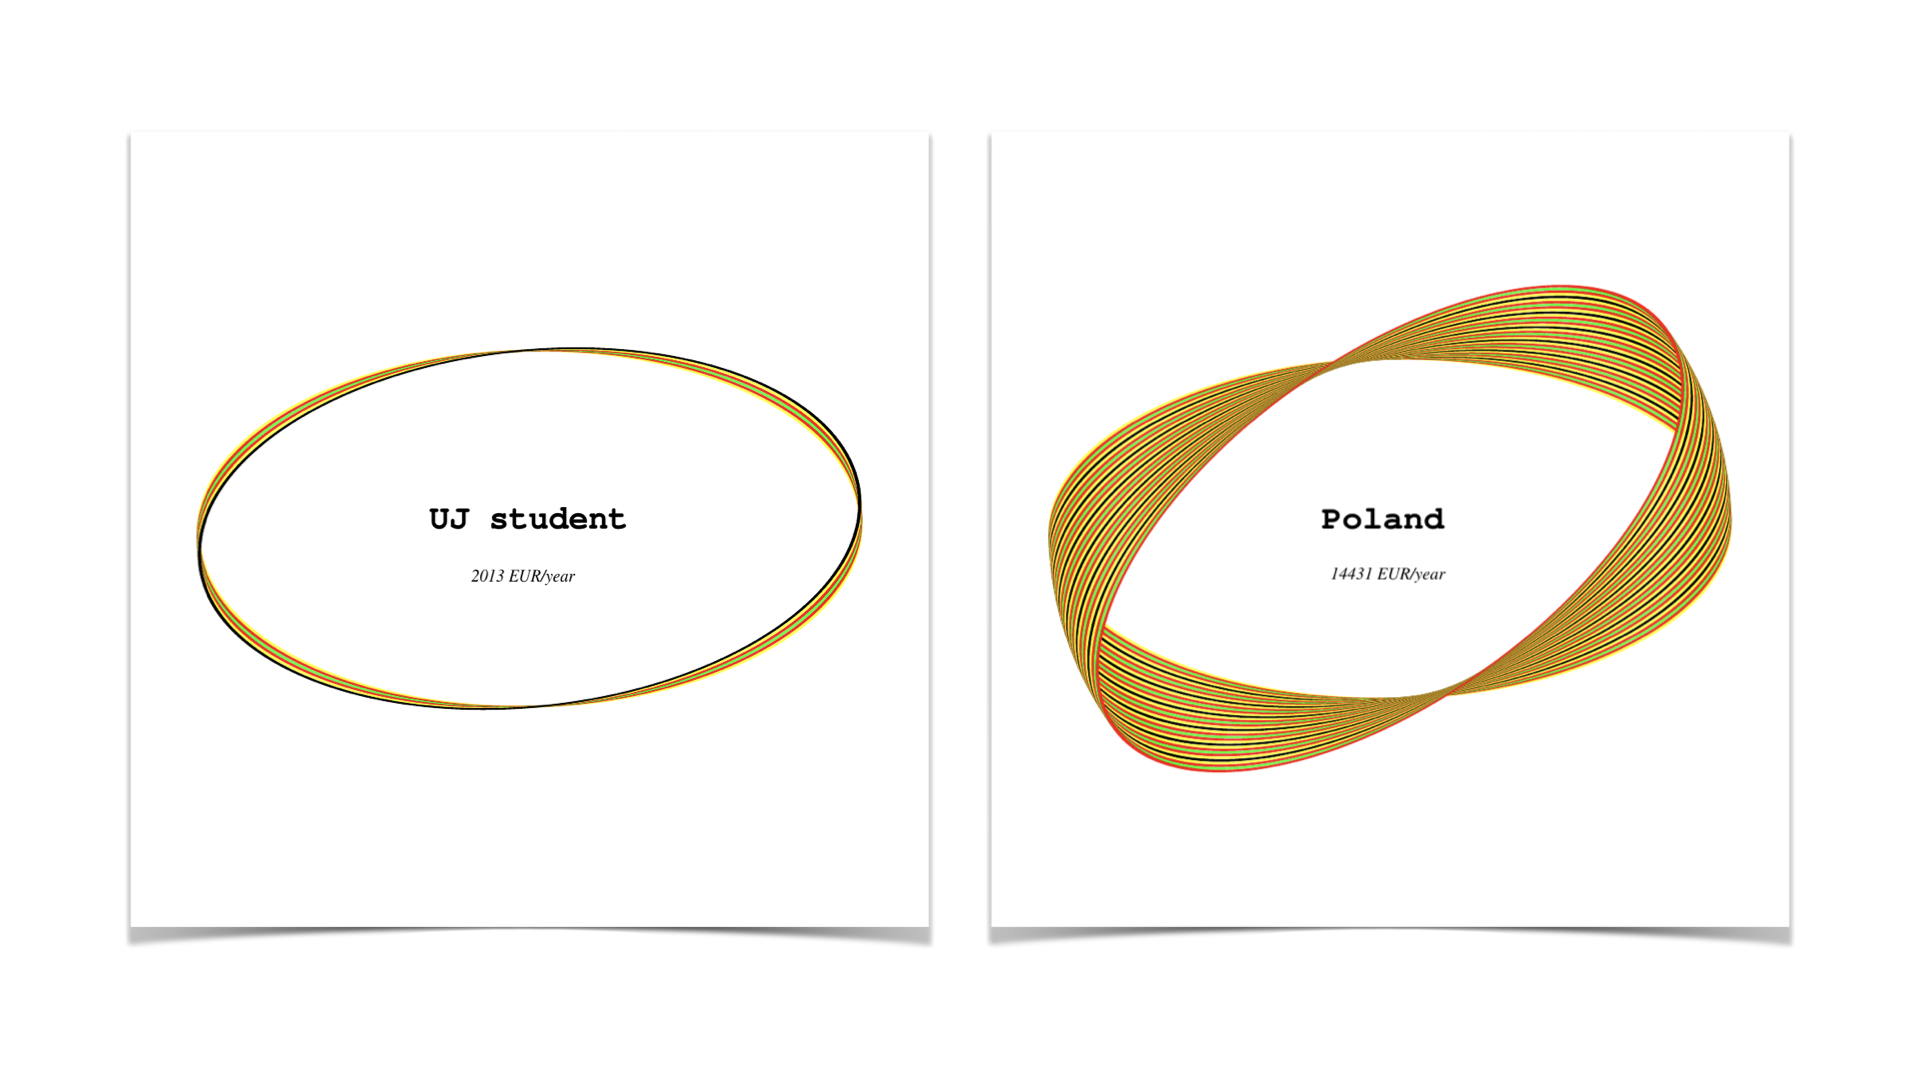

In [13]:
from IPython.display import Image, display
display(Image('samples/1.png', width=1300))


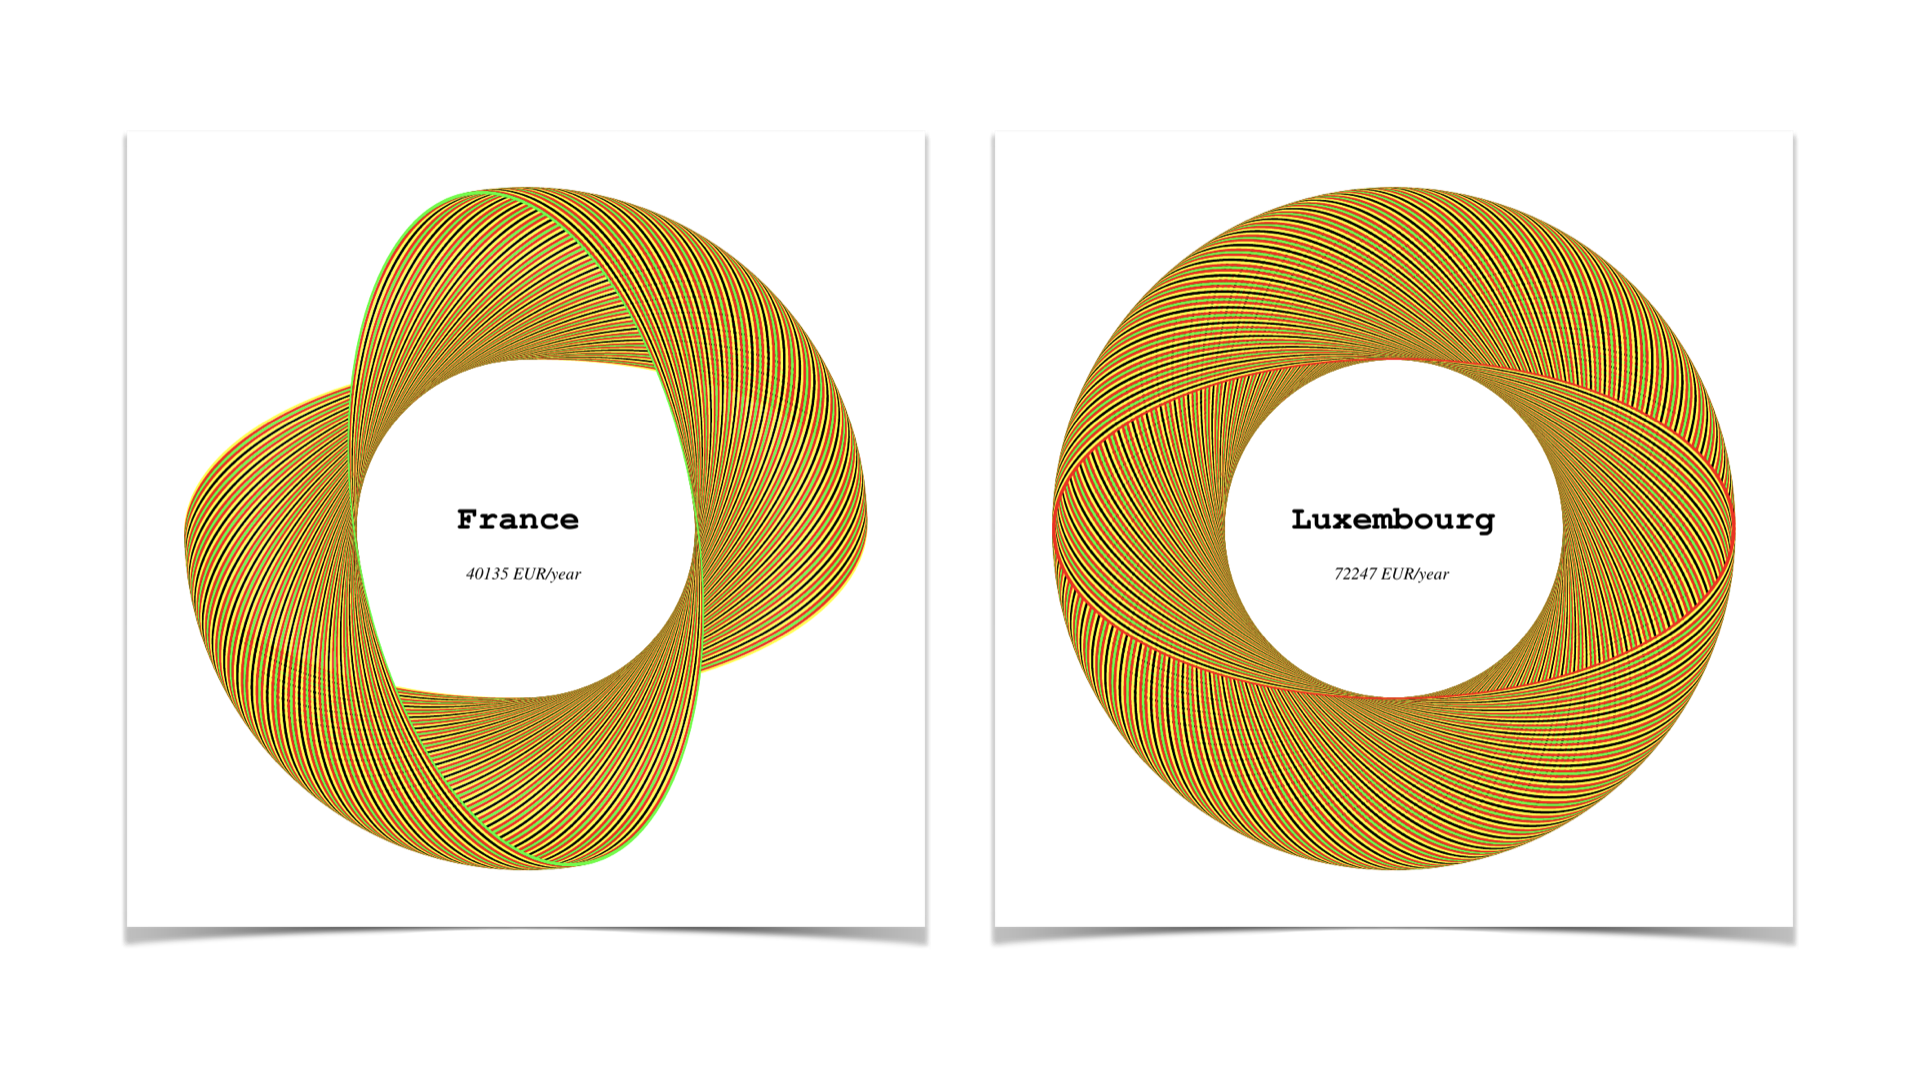

In [14]:
display(Image('samples/2.png', width=1300))

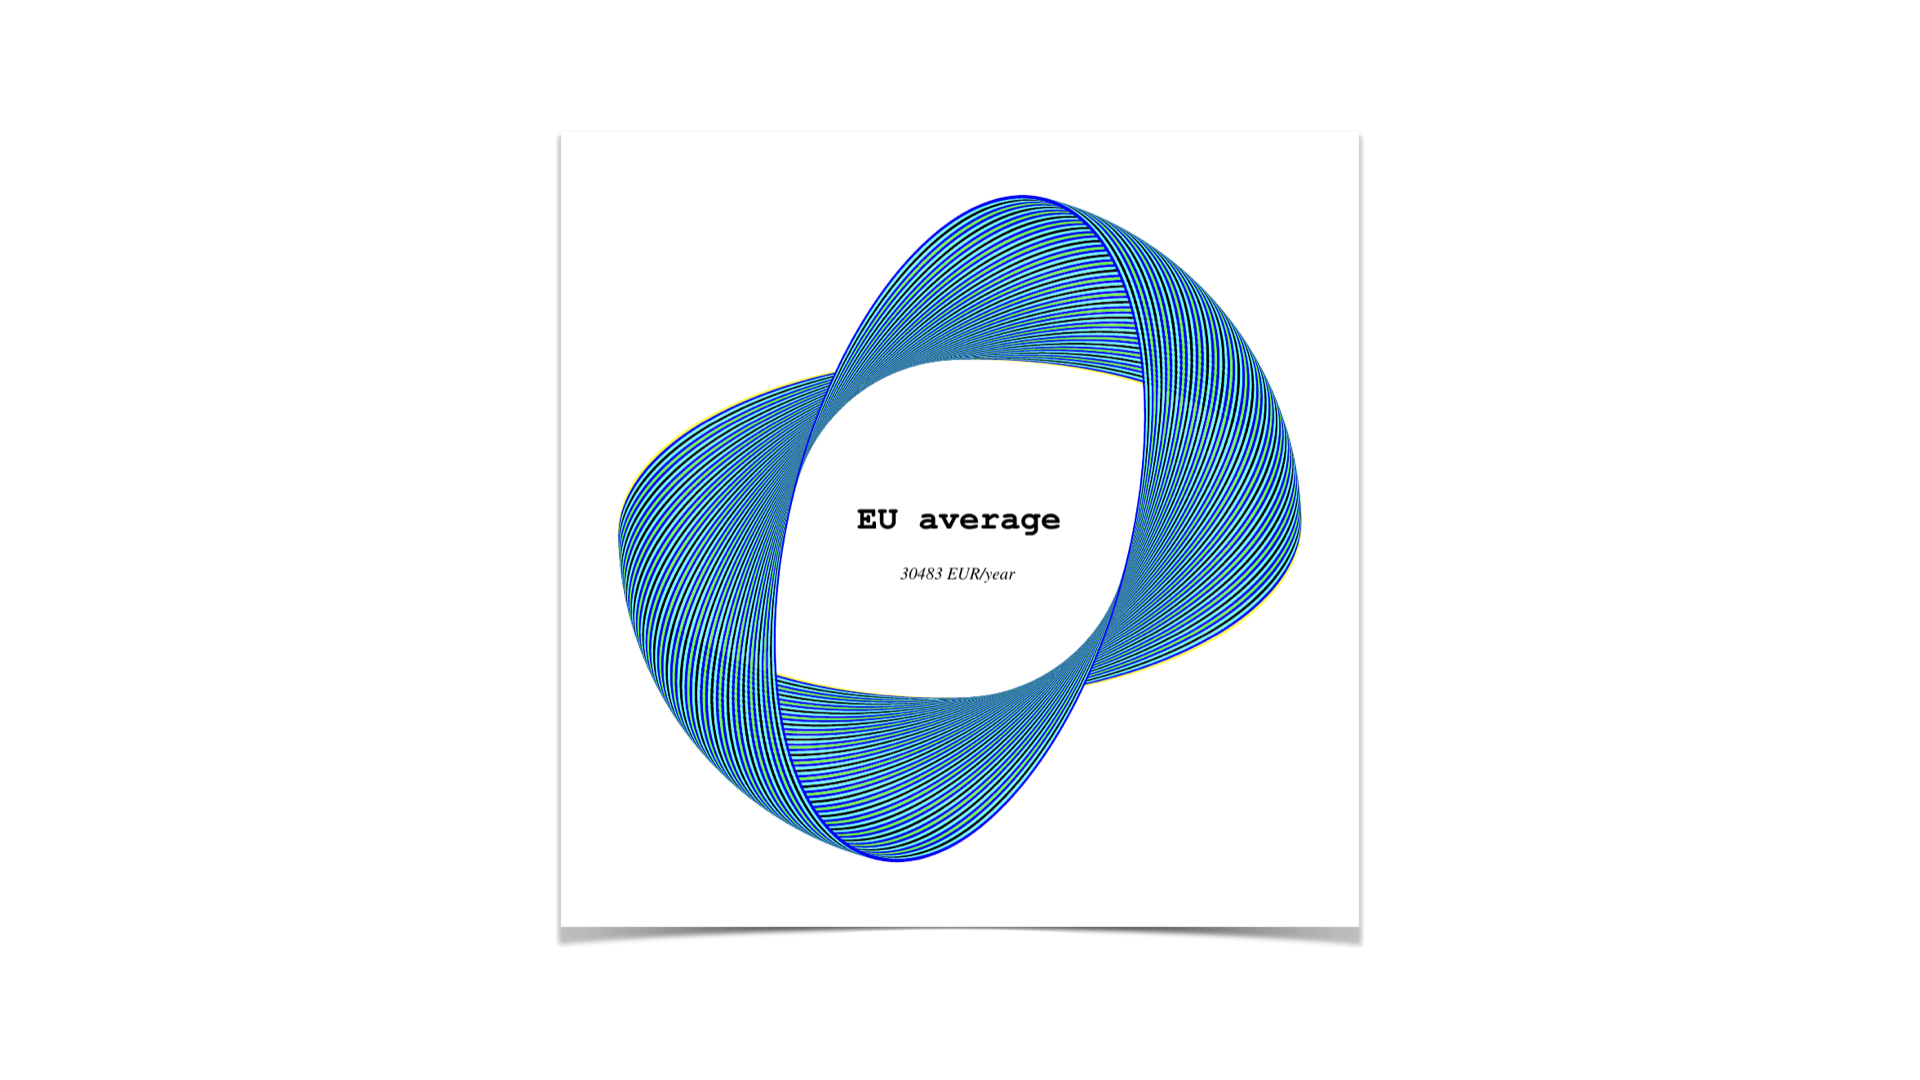

In [15]:
display(Image('samples/3.png', width=1300))

In [16]:
# Odtwarzanie przygotowanego filmiku
!mkdir dynamic_changes
import gdown
gdown.download('https://drive.google.com/file/d/10ZMJTPu_jymYsrKirRyUvKY4b6oSIWk3/view?usp=sharing', 
               'dynamic_changes/all.mp4', quiet=True, fuzzy=True)  

from IPython.display import HTML
from base64 import b64encode
import os

file = "dynamic_changes/all.mp4"
compressed = "dynamic_changes/all_compressed.mp4"
os.system(f"ffmpeg -i {file} -vcodec libx264 {compressed}")
mp4 = open(compressed,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [17]:
HTML("""<video width=1200 controls><source src="%s" type="video/mp4"></video>""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

# **Infografika**

In [18]:
!mkdir infographics
import gdown
gdown.download("https://drive.google.com/file/d/19q7Ur-tDf8fP9tgbaJ1uPgnihT0hfFcU/view?usp=sharing", "infographics/1.png", quiet=True, fuzzy=True)

'infographics/1.png'

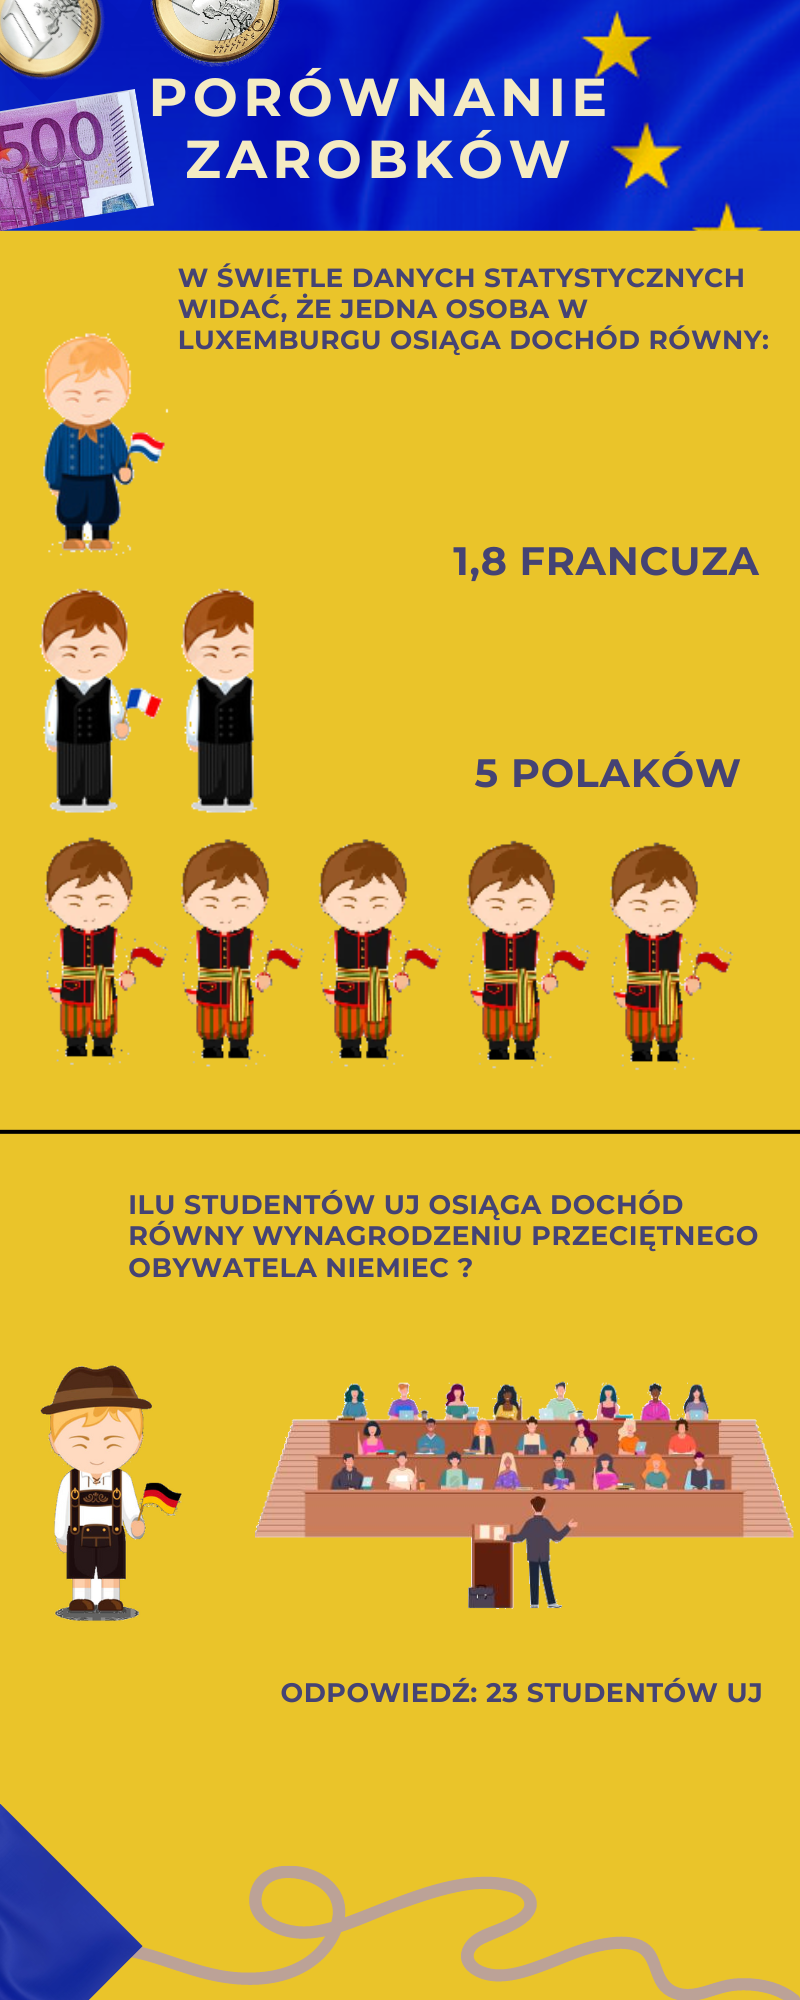

In [19]:
from IPython.display import Image, display
display(Image('infographics/1.png', width=500))